In [6]:
pip install scikit-learn

  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:

import tensorflow as tf
from Compute_Jacobian import jacobian
import numpy as np
import timeit

# Data Sampler
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    # Sample function
    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y
    

class NN_FF:
    #def __init__(self, layers, X_u, Y_u, a, u, sigma):
    def __init__(self, layers, X_u, Y_u, a, X_star, u_star, sigma):

        """
        :param layers: Layers of the network
        :param X_u, Y_u: Training data
        :param a:  Hyper-parameter of the target function
        :param u:  the target function
        :param sigma: Hyper-parameter of the Fourier features
        """

        self.mu_X, self.sigma_X = X_u.mean(0), X_u.std(0)
        #self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]

        # Normalize the input of the network
        self.X_u = (X_u - self.mu_X) / self.sigma_X
        self.Y_u = Y_u

        # Initialize Fourier features
        self.W = tf.Variable(tf.random_normal([1, layers[0] //2], dtype=tf.float32) * sigma, dtype=tf.float32, trainable=False)

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
            
        # Define the size of the Kernel
        self.D_u = X_u.shape[0]
        
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_ntk_tf = tf.placeholder(tf.float32, shape=(self.D_u, 1))

        # Evaluate predictions
        #self.u_pred = self.net_u(self.x_u_tf)
        self.u_pred = self.forward_pass(self.x_u_tf)

        # Evaluate NTK predictions
        #self.u_ntk_pred = self.net_u(self.x_u_ntk_tf)
        self.u_ntk_pred = self.forward_pass(self.x_u_ntk_tf)
     
        # Boundary loss
        self.loss_u = tf.reduce_mean(tf.square(self.u_pred - self.u_tf))   
        
        # Total loss
        self.loss = self.loss_u

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)

        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

        # Model Saver
        self.saver = tf.train.Saver()

        # Compute the Jacobian for weights and biases in each hidden layer
        self.J_u = self.compute_jacobian(self.u_ntk_pred)

        # The empirical NTK = J J^T, compute NTK of PINNs
        self.K = self.compute_ntk(self.J_u, self.x_u_ntk_tf, self.J_u, self.x_u_ntk_tf)

        # Loss Logger
        self.loss_u_log = []

        # NTK logger
        self.K_log = []

        # Weights logger
        self.weights_log = []
        self.biases_log = []

        # Training error and test error
        #N_train  = 100
        #N_test = 1000

        # Training data
        #self.X_train = np.linspace(0, 1, N_train)[:, None]
        #self.Y_train = u(self.X_train, a)
        self.X_train = self.X_u
        self.Y_train = self.Y_u
        
        # Test data
        #self.X_test = np.linspace(0, 1, N_test)[:, None]
        #self.Y_test = u(self.X_test, a)
        self.X_test = X_star
        self.Y_test = u_star

        # Error loggers
        self.train_error_log = []
        self.test_error_log = []

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # NTK initialization
    def NTK_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        std = 1. / np.sqrt(in_dim)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * std,
                           dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.random_normal([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluate the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        
        H = tf.concat([tf.sin(tf.matmul(H, self.W)),
                       tf.cos(tf.matmul(H, self.W))], 1) 

        for l in range(0, num_layers - 2): # number_layers  - 1?
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # Define the neural net
    #def net_u(self, x):
     #   u = self.forward_pass(x)
      #  return u

    # Compute Jacobian for each weights and biases in each layer and retrun a list
    def compute_jacobian(self, f):
        J_list =[]
        L = len(self.weights)
        for i in range(L):
            J_w = jacobian(f, self.weights[i])
            J_list.append(J_w)

        for i in range(L):
            J_b = jacobian(f, self.biases[i])
            J_list.append(J_b)
        return J_list

    # Compute the empirical NTK = J J^T
    def compute_ntk(self, J1_list, x1, J2_list, x2):
        D1 = x1.shape[0]
        D2 = x2.shape[0]
        N = len(J1_list)

        Ker = tf.zeros((D1, D2))
        for k in range(N):
            J1 = tf.reshape(J1_list[k], shape=(D1, -1))
            J2 = tf.reshape(J2_list[k], shape=(D2, -1))

            K = tf.matmul(J1, tf.transpose(J2))
            Ker = Ker + K
        return Ker

    # Fetch minibatch
    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, log_NTK=True, log_weights=True):

        start_time = timeit.default_timer()

        for it in range(nIter):
            # Fetch  mini-batches
            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_u_tf: self.X_u, self.u_tf: self.Y_u
                       }

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time

                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value = self.sess.run(self.loss_u, tf_dict)

                # Store the loss values
                self.loss_u_log.append(loss_u_value)

                # Compute the training error
                u_pred_train = self.predict_u(self.X_train)
                training_error = np.linalg.norm(self.Y_train - u_pred_train, 2) / np.linalg.norm(self.Y_train, 2)

                # Compute the test error
                u_pred_test = self.predict_u(self.X_test)
                test_error = np.linalg.norm(self.Y_test - u_pred_test, 2) / np.linalg.norm(self.Y_test, 2)

                # Store the training and test errors
                self.train_error_log.append(training_error)
                self.test_error_log.append(test_error)

                # print the loss values
                print('It: %d, Loss: %.3e, Loss_bcs: %.3e,Time: %.2f' %
                      (it, loss_value, loss_u_value, elapsed))

                start_time = timeit.default_timer()

            # Store the NTK matrix for every 100 iterations
            if log_NTK:
                # provide x, x' for NTK
                if it % 100 == 0:
                    print("Compute NTK...")
                    tf_dict = {self.x_u_ntk_tf: self.X_u}
                    K_value = self.sess.run(self.K, tf_dict)
                    self.K_log.append(K_value)

            # Store the weights and biases of the network for every 100 iterations
            if log_weights:
                if it % 100 ==0:
                    print("Weights stored...")
                    weights = self.sess.run(self.weights)
                    biases = self.sess.run(self.biases)
                    
                    self.weights_log.append(weights)
                    self.biases_log.append(biases)
                
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star




In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xlrd openpyxl

Device mapping:

It: 0, Loss: 1.729e-01, Loss_bcs: 1.729e-01,Time: 0.26
Compute NTK...
Weights stored...
It: 0, Loss: 1.127e-01, Loss_bcs: 1.127e-01,Time: 0.01
Compute NTK...
Weights stored...
It: 0, Loss: 7.186e-02, Loss_bcs: 7.186e-02,Time: 0.01
Compute NTK...
Weights stored...
It: 100, Loss: 6.492e-03, Loss_bcs: 6.492e-03,Time: 1.99
Compute NTK...
Weights stored...
It: 200, Loss: 1.505e-03, Loss_bcs: 1.505e-03,Time: 2.15
Compute NTK...
Weights stored...
It: 300, Loss: 1.218e-03, Loss_bcs: 1.218e-03,Time: 1.90
Compute NTK...
Weights stored...
It: 400, Loss: 1.073e-03, Loss_bcs: 1.073e-03,Time: 2.12
Compute NTK...
Weights stored...
It: 500, Loss: 9.821e-04, Loss_bcs: 9.821e-04,Time: 2.01
Compute NTK...
Weights stored...
It: 600, Loss: 9.180e-04, Loss_bcs: 9.180e-04,Time: 2.07
Compute NTK...
Weights stored...
It: 700, Loss: 8.697e-04, Loss_bcs: 8.697e-04,Time: 2.14
Compute NTK...
Weights stored...
It: 800, Loss: 8.310e-04, Loss_bcs: 8.310e-04,Time: 1.96
Compute NTK...
Weights stored...

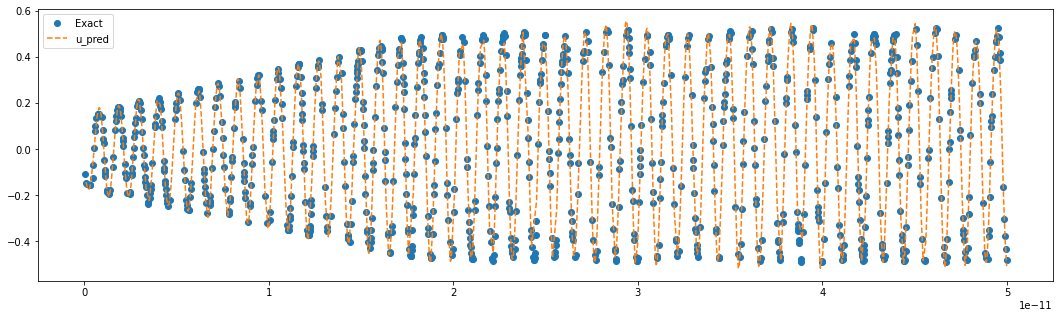

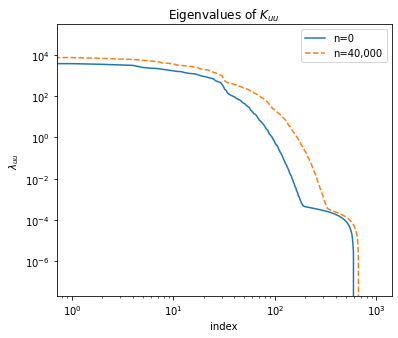

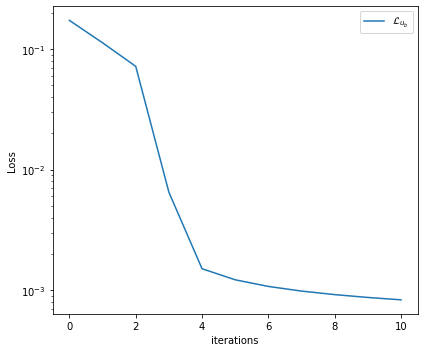

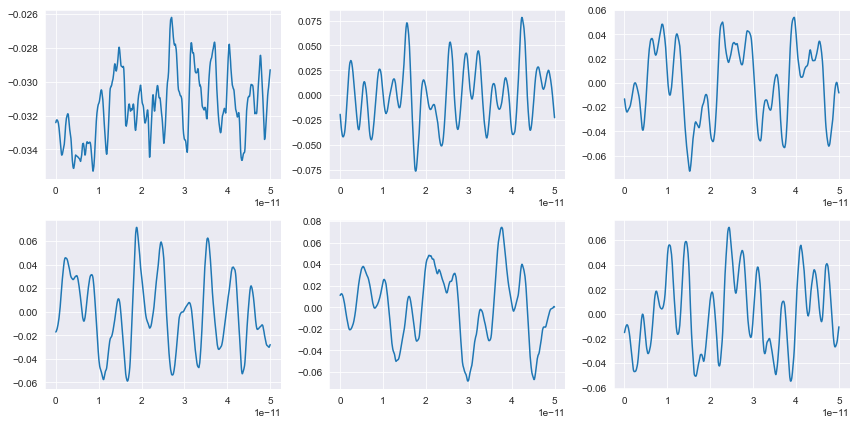

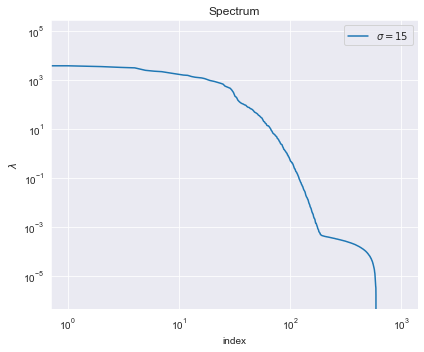

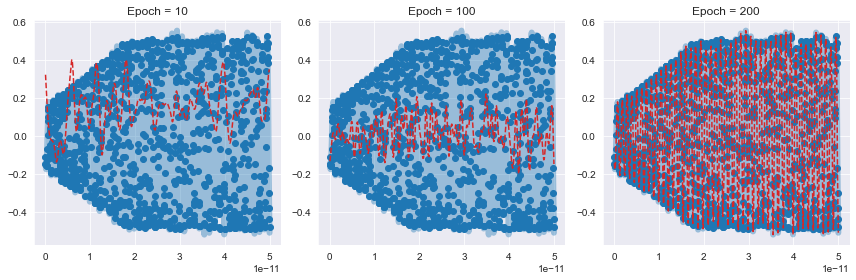

In [6]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from models_tf import Sampler, NN_FF

from sklearn.model_selection import train_test_split
import pandas as pd


if __name__ == '__main__':

    # Load your Excel data file
    data_file = '../40nm_300K.xlsx'  # Ensure this path is correct
    df = pd.read_excel(data_file, engine='openpyxl', skiprows=3)

    # Extract the first two columns for X and Y
    X = df.iloc[:, 2].values[:, None]  # First column for X
    Y = df.iloc[:, 3].values[:, None]  # Second column for Y

    # Split the data into 1000 training and 1000 testing points
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=1000, test_size=1000, shuffle=True, random_state=42)
#     X_train = X
#     Y_train = Y
#     X_test = X
#     Y_test = Y
    
    
    # Define solution and its Laplace
    #def u(x, a):
        #return np.sin(np.pi * x) +  np.cos(np.pi * a * x)
        #return (0.1 * np.sin(np.pi * x * a))
    
    

    # Define computational domain
    #dom_coords = np.array([[0.0],
                           #[5e-12]])
    
    #dom_coords = np.array([[X_train.min()],
     #                      [X_train.max()]])

    # Training data on u(x) 
    N_u = 1000
    #X_u = np.linspace(dom_coords[0, 0],
     #                 dom_coords[1, 0], N_u)[:, None]
    
    X_u = X_train
    
    a = 2*1e13
    #Y_u = u(X_u, a)
    
    Y_u = Y_train
    
    # Test data
    nn = 1000
    #X_star = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    #u_star = u(X_star, a)
    
    X_star = X_test
    u_star = Y_test
    
    # Define the model
    layers = [100, 100, 100, 1]
    sigma = 15   # Hyper-parameter of the Fourier features
    #model = NN_FF(layers, X_u, Y_u, a, u,  sigma)
    model = NN_FF(layers, X_u, Y_u, a,  X_star, u_star,  sigma)
    
    # Train the model for different epochs
    epoch_list = [10, 90, 900]  # 1000 iterations in total
    u_pred_list = []

    for epoch in epoch_list:
       # Train the model
       model.train(nIter=epoch, log_NTK=True, log_weights=True)
       
       # Predictions
       u_pred = model.predict_u(X_star)
       u_pred_list.append(u_pred)

    # Evaulate the relative l2 error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    print('Relative L2 error_u: {:.2e}'.format(error_u))

    # Create loggers for the eigenvalues of the NTK
    lambda_K_log = []

    # Restore the NTK
    K_list = model.K_log

    for k in range(len(K_list)):
        K = K_list[k]

        # Compute eigenvalues
        lambda_K, eigvec_K = np.linalg.eig(K)
        
        # Sort in descresing order
        lambda_K = np.sort(np.real(lambda_K))[::-1]
        
        # Store eigenvalues
        lambda_K_log.append(lambda_K)
        
    # Change of the NTK
    kernel_diff_list = []
    K0 = K_list[0]
    for K in K_list:
        diff = np.linalg.norm(K - K0) / np.linalg.norm(K0) 
        kernel_diff_list.append(diff)

    #######################
    #######################
    
    # Change of the weights
    def compute_weights_diff(weights_1, weights_2):
        weights = []
        N = len(weights_1)
        for k in range(N):
            weight = weights_1[k] - weights_2[k]
            weights.append(weight)
        return weights
    
    def compute_weights_norm(weights, biases):
        norm = 0
        for w in weights:
            norm = norm + np.sum(np.square(w))
        for b in biases:
            norm = norm + np.sum(np.square(b))
        norm = np.sqrt(norm)
        return norm
    
    # Restore the list weights and biases
    weights_log = model.weights_log
    biases_log = model.biases_log

    # The weights and biases at initialization
    weights_0 = weights_log[0]
    biases_0 = biases_log[0]
    
    weights_init_norm = compute_weights_norm(weights_0, biases_0)

    weights_change_list = []

    # Compute the change of weights and biases of the network
    N = len(weights_log)
    for k in range(N):
        weights_diff = compute_weights_diff(weights_log[k], weights_log[0])
        biases_diff = compute_weights_diff(biases_log[k], biases_log[0])
        
        weights_diff_norm = compute_weights_norm(weights_diff, biases_diff)
        weights_change = weights_diff_norm / weights_init_norm
        weights_change_list.append(weights_change)
    

    #################################
    ############## PLot##############
    #################################
    
    train_indices = np.argsort(X_u, axis=0).flatten()
    X_train_sorted = X_u[train_indices]
    Y_train_sorted = Y_u[train_indices]

    # Sort test data
    test_indices = np.argsort(X_star, axis=0).flatten()
    X_star_sorted = X_star[test_indices]
    u_pred_sorted = u_pred[test_indices]
    
    u_pred_epoc_10 = u_pred_list[0]
    u_pred_epoc_10_sorted = u_pred_epoc_10[test_indices]
    u_pred_epoc_100 = u_pred_list[1]
    u_pred_epoc_100_sorted = u_pred_epoc_100[test_indices]
    u_pred_epoc_200 = u_pred_list[2]
    u_pred_epoc_200_sorted = u_pred_epoc_200[test_indices]
    
    eigvec_K_0 = np.real(eigvec_K[:,0])
    eigvec_K_0_sorted = eigvec_K_0[train_indices]
    eigvec_K_1 = np.real(eigvec_K[:,1])
    eigvec_K_1_sorted = eigvec_K_1[train_indices]
    eigvec_K_2 = np.real(eigvec_K[:,2])
    eigvec_K_2_sorted = eigvec_K_2[train_indices]
    eigvec_K_3 = np.real(eigvec_K[:,3])
    eigvec_K_3_sorted = eigvec_K_3[train_indices]
    eigvec_K_4 = np.real(eigvec_K[:,4])
    eigvec_K_4_sorted = eigvec_K_4[train_indices]
    eigvec_K_5 = np.real(eigvec_K[:,5])
    eigvec_K_5_sorted = eigvec_K_5[train_indices]
    
    # Model predictions
    #fig = plt.figure(1, figsize=(40, 5))
    #plt.subplot(1,2,1)
    #plt.plot(X_u, Y_u, '--', label='Exact')
    #plt.plot(X_star, u_pred, '--', label='u_pred')
    #plt.legend()
    
    fig = plt.figure(1, figsize=(40, 5))
    plt.subplot(1,2,1)
    plt.plot(X_train_sorted, Y_train_sorted, 'o', label='Exact')
    plt.plot(X_star_sorted, u_pred_sorted, '--', label='u_pred')
    plt.legend()
    
    #plt.subplot(1,2,2)
    #plt.plot(X_star, u_star - u_pred, label='Error')
    #plt.legend()
    #plt.tight_layout()
    #plt.show()
    
    # Eigenvalues of NTK
    fig = plt.figure(2, figsize=(6, 5))
    plt.plot(lambda_K_log[0], label = 'n=0')
    plt.plot(lambda_K_log[-1], '--', label = 'n=40,000')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('index')
    plt.ylabel(r'$\lambda_{uu}$')
    plt.title(r'Eigenvalues of ${K}_{uu}$')
    plt.legend()
    plt.show()

    # Loss values
    loss_u = model.loss_u_log
    fig_3 = plt.figure(3, figsize=(6,5))
    plt.plot(loss_u, label='$\mathcal{L}_{u_b}$')
    plt.yscale('log')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    


#     # Visualize the eigenvectors of the NTK
#     fig = plt.figure(figsize=(12, 6))
#     with sns.axes_style("darkgrid"):
#         plt.subplot(2,3,1)
#         plt.plot(X_u,  np.real(eigvec_K[:,0]))
#         plt.tight_layout()
        
#         plt.subplot(2,3,2)
#         plt.plot(X_u,  np.real(eigvec_K[:,1]))
#         plt.tight_layout()
        
#         plt.subplot(2,3,3)
#         plt.plot(X_u,  np.real(eigvec_K[:,2]))
#         plt.tight_layout()
        
#         plt.subplot(2,3,4)
#         plt.plot(X_u,  np.real(eigvec_K[:,3]))
#         plt.tight_layout()
    
#         plt.subplot(2,3,5)
#         plt.plot(X_u,  np.real(eigvec_K[:,4]))
#         plt.tight_layout()
        
#         plt.subplot(2,3,6)
#         plt.plot(X_u,  np.real(eigvec_K[:,5]))
    
#         plt.tight_layout()
#         plt.show()
        
    # Visualize the eigenvectors of the NTK
    fig = plt.figure(figsize=(12, 6))
    with sns.axes_style("darkgrid"):
        plt.subplot(2,3,1)
        plt.plot(X_train_sorted,  eigvec_K_0_sorted)
        plt.tight_layout()
        
        plt.subplot(2,3,2)
        plt.plot(X_train_sorted,  eigvec_K_1_sorted)
        plt.tight_layout()
        
        plt.subplot(2,3,3)
        plt.plot(X_train_sorted,  eigvec_K_2_sorted)
        plt.tight_layout()
        
        plt.subplot(2,3,4)
        plt.plot(X_train_sorted,  eigvec_K_3_sorted)
        plt.tight_layout()
    
        plt.subplot(2,3,5)
        plt.plot(X_train_sorted,  eigvec_K_4_sorted)
        plt.tight_layout()
        
        plt.subplot(2,3,6)
        plt.plot(X_train_sorted,  eigvec_K_5_sorted)
    
        plt.tight_layout()
        plt.show()
    
    # Visualize the eigenvalues of the NTK
    fig = plt.figure(figsize=(6, 5))
    with sns.axes_style("darkgrid"):
        plt.plot(lambda_K_log[0], label=r'$\sigma={}$'.format(sigma))
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('index')
        plt.ylabel(r'$\lambda$') 
        plt.title('Spectrum')
        plt.tight_layout()
        plt.legend()
        plt.show()
        
        
#     # Model predictions at different epoch
#     fig = plt.figure(figsize=(12,4))
#     with sns.axes_style("darkgrid"):
#         plt.subplot(1,3,1)
#         plt.plot(X_u, Y_u, 'o')
#         plt.plot(X_star,  u_star, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star,  u_pred_list[0], color='C3', linestyle='--')
#         plt.title('Epoch = 10')
#         plt.tight_layout()
        
#         plt.subplot(1,3,2)
#         plt.plot(X_u, Y_u, 'o')
#         plt.plot(X_star,  u_star, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star,  u_pred_list[1], color='C3', linestyle='--')
#         plt.title('Epoch = 100')
#         plt.tight_layout()
        
#         plt.subplot(1,3,3)
#         plt.plot(X_u, Y_u, 'o')
#         plt.plot(X_star,  u_star, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star,  u_pred_list[2], color='C3', linestyle='--')
#         plt.title('Epoch = 200')
#         plt.tight_layout()
#         plt.show()
        
        
    # Model predictions at different epoch
    fig = plt.figure(figsize=(12,4))
    with sns.axes_style("darkgrid"):
        plt.subplot(1,3,1)
        plt.plot(X_train_sorted, Y_train_sorted, 'o')
        plt.plot(X_star_sorted,  u_pred_sorted, color = 'C0', alpha=0.4, linewidth=6)
        plt.plot(X_star_sorted,  u_pred_epoc_10_sorted, color='C3', linestyle='--')
        plt.title('Epoch = 10')
        plt.tight_layout()
        
        plt.subplot(1,3,2)
        plt.plot(X_train_sorted, Y_train_sorted, 'o')
        plt.plot(X_star_sorted,  u_pred_sorted, color = 'C0', alpha=0.4, linewidth=6)
        plt.plot(X_star_sorted,  u_pred_epoc_100_sorted, color='C3', linestyle='--')
        plt.title('Epoch = 100')
        plt.tight_layout()
        
        plt.subplot(1,3,3)
        plt.plot(X_train_sorted, Y_train_sorted, 'o')
        plt.plot(X_star_sorted,  u_pred_sorted, color = 'C0', alpha=0.4, linewidth=6)
        plt.plot(X_star_sorted,  u_pred_epoc_200_sorted, color='C3', linestyle='--')
        plt.title('Epoch = 200')
        plt.tight_layout()
        plt.show()

In [1]:
import tensorflow as tf
print(tf.__version__)

1.15.5
